In [14]:
import simpy
import numpy as np
from numpy.random import RandomState, randint
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Arrival rate and length of stay inputs.
ARR_RATE = 0.3 # from 0 to 1, numbers more than 1 give higher arrival rate
MEAN_LOS_TREATMENT = 3

CAPACITY_WAITING_ROOM = 50

CAPACITY_TREATMENT_1 = 3
CAPACITY_TREATMENT_2 = 8
CAPACITY_TREATMENT_3 = 5

CAPACITY_DOCTOR_MINOR = 3
CAPACITY_DOCTOR_MAJOR = 7
# Run the simulation for a while
RUNTIME = 150

Treatment_Waiting_Times = [ ]
Doctor_Waiting_Times = [ ]

Doctor_UnderUtilized_minor = [ ]
Doctor_UnderUtilized_major = [ ]
WaitingRoom_Utilization = [ ]

Minor_1_TreatmentRoomUtilization = [ ]
Major_2_TreatmentRoomUtilization = [ ]
Resus_3_TreatmentRoomUtilization = [ ]


RNG_SEED = 420

In [16]:
def patient_generator(env, arr_rate, prng=RandomState(0)):
    
    """Generates patients according to Poisson distribution

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        arr_rate : float
            exponential arrival rate
        prng : RandomState object
            Seeded RandomState object
    """

    patients_created = 0

    # Infinite loop for generating patients according to a poisson process.
    while True:

        global CAPACITY_WAITING_ROOM
        # Generate next interarrival time
        iat = prng.exponential(1.0 / arr_rate)

        # Monitor Waiting Room Capacity
        WaitingRoom_Utilization.append(CAPACITY_WAITING_ROOM)

        if CAPACITY_WAITING_ROOM != 0:
        # Generate length of stay in treatment unit with doctor for this patient
            los_treatment = prng.exponential(MEAN_LOS_TREATMENT)

            # Update counter of patients
            patients_created += 1
            CAPACITY_WAITING_ROOM -= 1

            

            # Create a new patient flow process.
            ED = ED_patient_flow(env, 'Patient{}'.format(patients_created),
                                los_treatment=los_treatment)

            # Register the process with the simulation environment
            env.process(ED)

        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

In [17]:
def ED_patient_flow(env, name, los_treatment):
    """Simulate Patient flow in ED

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        name : str
            process instance id
        los_treatment : float
            length of stay in treatment unit
    """
    global CAPACITY_WAITING_ROOM

    # Event 1 --- Assign Treatment unit to patient-----------------------------------------------------------
    # Assign Random Severity to patient
    patientSeverity = randint(1,4) # Assign random severity from 1 to 3, 3 is highest severity
    requestedUnit = 1 # Placeholder value for requestedUnit type
    requestedDoctor = 1 # Placeholder value for requestedDoctor type

    print("{} with Severity {} trying to get into Treatment at {}".format(name, patientSeverity, env.now))


    # Timestamp when patient tried to get into treatment room
    treatment_unit_request_ts = env.now
    # Request a treatment unit based on severity, patient will get higher LOS_treatment if they have higher severity
    if patientSeverity == 1:
        treatment_unit_request_severity = treatment_unit_severity_1.request()
        requestedUnit = 1
    elif patientSeverity == 2:
        treatment_unit_request_severity = treatment_unit_severity_2.request()
        requestedUnit = 2
        los_treatment = los_treatment + 1
    else:
        treatment_unit_request_severity = treatment_unit_severity_3.request()
        requestedUnit = 3
        los_treatment = los_treatment + 4
    
    
    numberofUnderUtilized_minor = CAPACITY_DOCTOR_MINOR - doctor_unit_minor.count
    numberofUnderUtilized_major = CAPACITY_DOCTOR_MAJOR - doctor_unit_major.count
    Doctor_UnderUtilized_minor.append(numberofUnderUtilized_minor)
    print("At {} , Number of under-utilized minor doctors: {}".format(env.now, numberofUnderUtilized_minor))
    Doctor_UnderUtilized_major.append(numberofUnderUtilized_major)
    print("At {} , Number of under-utilized major doctors: {}".format(env.now, numberofUnderUtilized_major))

    minor_1_TreatmentRoomUtilization = CAPACITY_TREATMENT_1 - treatment_unit_severity_1.count
    major_2_TreatmentRoomUtilization = CAPACITY_TREATMENT_2 - treatment_unit_severity_2.count
    resus_3_TreatmentRoomUtilization = CAPACITY_TREATMENT_3 - treatment_unit_severity_3.count

    Minor_1_TreatmentRoomUtilization.append(minor_1_TreatmentRoomUtilization)
    Major_2_TreatmentRoomUtilization.append(major_2_TreatmentRoomUtilization)
    Resus_3_TreatmentRoomUtilization.append(resus_3_TreatmentRoomUtilization)

    # Yield this process until a treatment unit is available
    yield treatment_unit_request_severity
    # Patient got into treatment unit

    print("{} with Severity {} entering Treatment at {}".format(name, patientSeverity, env.now))
    CAPACITY_WAITING_ROOM += 1

    # Let's see if we had to wait to get to the treatment unit
    if env.now > treatment_unit_request_ts:
        treatment_unit_waiting_time = env.now - treatment_unit_request_ts
        print("{} waited {} time units to enter Treatment room".format(name, treatment_unit_waiting_time))
        Treatment_Waiting_Times.append(treatment_unit_waiting_time)
    else:
        Treatment_Waiting_Times.append(0)

    #------------------------------------------------------------------------
    ##################################################################################################
    # Event 2 - Inside treatment, Request Doctor-------------------------------------------------------

    # Timestamp when patient tried to get doctor request
    doctor_unit_request_ts = env.now
    # Request a doctor based on patient severity, minor treats severity 1, major treats severity 2 and 3
    if patientSeverity == 1:
        doctor_unit_request = doctor_unit_minor.request()
        requestedDoctor = 1
    elif patientSeverity == 2:
        doctor_unit_request = doctor_unit_major.request(2)
        requestedDoctor = 2
    else:
        doctor_unit_request = doctor_unit_major.request(1) # given higher priority by lower request number
        requestedDoctor = 2

    # Yield this process until a doctor is available
    yield doctor_unit_request
    # We got a doctor
    print("{} with Severity {} has doctor treating them at {}".format(name, patientSeverity, env.now))
    # Let's see if we had to wait to get the doctor.
    if env.now > doctor_unit_request_ts:
        doctor_unit_waiting_time = env.now - doctor_unit_request_ts
        print("{} with Severity {} waited {} time units for Doctor".format(name, patientSeverity , doctor_unit_waiting_time))
        Doctor_Waiting_Times.append(doctor_unit_waiting_time)
    else:
        Doctor_Waiting_Times.append(0)


    # Timestamp when patient tried to get doctor
    waited_in_treatment = env.now
    # Yield this process again. Now wait until length of stay elapses.
    # This is the actual stay in the treatment unit
    yield env.timeout(los_treatment)

    # All done with Treatment, release the treatment unit and doctor, and make them available
    if requestedUnit == 1:
        treatment_unit_severity_1.release(treatment_unit_request_severity)
    elif requestedUnit == 2:
        treatment_unit_severity_2.release(treatment_unit_request_severity)
    elif requestedUnit == 3:
        treatment_unit_severity_3.release(treatment_unit_request_severity)
    print("{} leaving Treatment at {}".format(name, env.now))

    if requestedDoctor == 1:
        doctor_unit_minor.release(doctor_unit_request)
    elif requestedDoctor == 2:
        doctor_unit_major.release(doctor_unit_request)
    print("Doctor is now free at {}".format(env.now))
    #-------------------------------------------------------------------------------------------------------------
    ##############################################################################################################

    # Waiting Time for treatment room
    print("{} has stayed {} time units at treatment room".format(name, env.now - waited_in_treatment))



In [18]:
# Initialize a simulation environment
env = simpy.Environment()

# Initialize a random number generator.
prng = RandomState(RNG_SEED)

# Declare a Resource to model ED with treatment units and doctor units. We pass in desired capacity.
treatment_unit_severity_1 = simpy.Resource(env, CAPACITY_TREATMENT_1)
treatment_unit_severity_2 = simpy.Resource(env, CAPACITY_TREATMENT_2)
treatment_unit_severity_3 = simpy.Resource(env, CAPACITY_TREATMENT_3)

doctor_unit_minor = simpy.Resource(env , CAPACITY_DOCTOR_MINOR)
doctor_unit_major = simpy.PriorityResource(env , CAPACITY_DOCTOR_MAJOR )

env.process(patient_generator(env, ARR_RATE, prng))
env.run(until=RUNTIME)

Patient1 with Severity 3 trying to get into Treatment at 0
At 0 , Number of under-utilized minor doctors: 3
At 0 , Number of under-utilized major doctors: 7
Patient1 with Severity 3 entering Treatment at 0
Patient1 with Severity 3 has doctor treating them at 0
Patient2 with Severity 1 trying to get into Treatment at 0.3792798265739865
At 0.3792798265739865 , Number of under-utilized minor doctors: 3
At 0.3792798265739865 , Number of under-utilized major doctors: 6
Patient2 with Severity 1 entering Treatment at 0.3792798265739865
Patient2 with Severity 1 has doctor treating them at 0.3792798265739865
Patient3 with Severity 2 trying to get into Treatment at 0.689865207359152
At 0.689865207359152 , Number of under-utilized minor doctors: 2
At 0.689865207359152 , Number of under-utilized major doctors: 6
Patient3 with Severity 2 entering Treatment at 0.689865207359152
Patient3 with Severity 2 has doctor treating them at 0.689865207359152
Patient2 leaving Treatment at 0.725270579529115
Doct

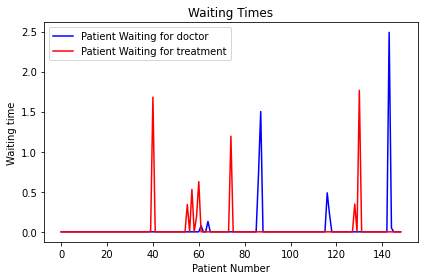

In [19]:
plt.plot(Doctor_Waiting_Times,color='blue',label='Patient Waiting for doctor')
plt.plot(Treatment_Waiting_Times,color='red',label = 'Patient Waiting for treatment')
plt.title("Waiting Times")
plt.ylabel('Waiting time')
plt.xlabel('Patient Number')
plt.legend()
plt.tight_layout()
plt.show()

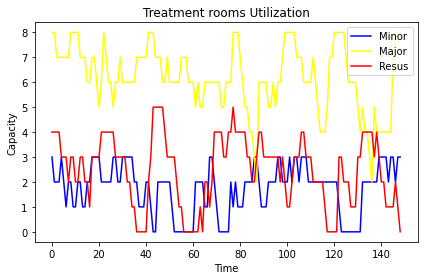

In [20]:
plt.plot(Minor_1_TreatmentRoomUtilization,color='blue',label='Minor')
plt.plot(Major_2_TreatmentRoomUtilization,color='yellow',label = 'Major')
plt.plot(Resus_3_TreatmentRoomUtilization,color='red',label=  'Resus')
plt.title("Treatment rooms Utilization")
plt.ylabel('Capacity')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


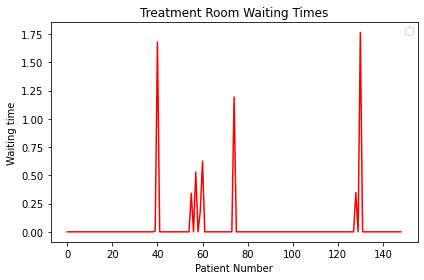

In [21]:
plt.plot(Treatment_Waiting_Times,color='red')
plt.title("Treatment Room Waiting Times")
plt.ylabel('Waiting time')
plt.xlabel('Patient Number')
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


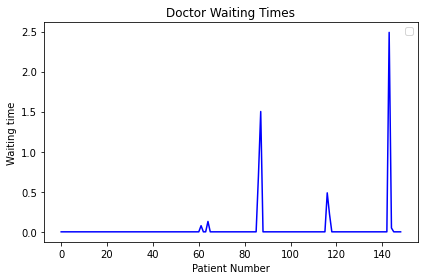

In [22]:
plt.plot(Doctor_Waiting_Times,color='blue')
plt.title("Doctor Waiting Times")
plt.ylabel('Waiting time')
plt.xlabel('Patient Number')
plt.legend()
plt.tight_layout()
plt.show()

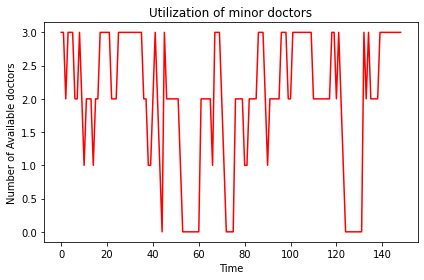

In [23]:
plt.plot(Doctor_UnderUtilized_minor,color='red',label = 'Under utilized minor doctors')
plt.title("Utilization of minor doctors")
plt.ylabel('Number of Available doctors')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

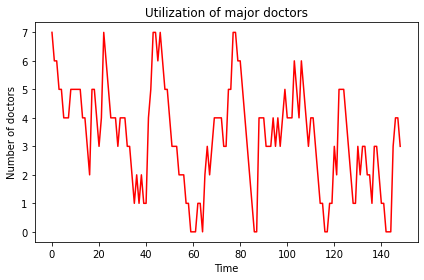

In [24]:
plt.plot(Doctor_UnderUtilized_major,color='red',label = 'Utilization of major doctors')
plt.title("Utilization of major doctors")
plt.ylabel('Number of doctors')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

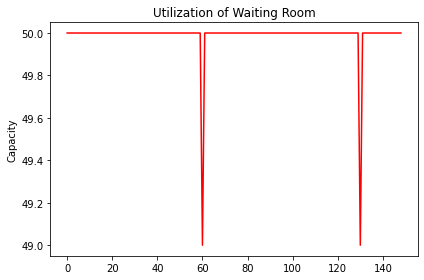

In [25]:
plt.plot(WaitingRoom_Utilization, color = 'red' , label = 'Waiting Room Capacity')
plt.title("Utilization of Waiting Room")
plt.ylabel("Capacity")
plt.tight_layout()
plt.show()

In [26]:
values,counts = np.unique(WaitingRoom_Utilization , return_counts=True)
print("Number of Abandoned patients: " , counts[0])
print("Number of patients entering ED: ", sum(counts) - counts[0])
print("Total Number of patients: ", sum(counts))

Number of Abandoned patients:  2
Number of patients entering ED:  147
Total Number of patients:  149
